In [1]:
from transformers import BertModel, BertTokenizer, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
np.random.seed(42)

# Unsupervised Sentiment Analysis

In [3]:
def get_embeddings(model, tokenizer, texts, device='cuda'):
    """Returns the [CLS] token sequence output of the given text"""
    sentence_embeddings = []
    device = torch.device(device)
    
    for batch_idx in tqdm(range(len(texts))):
        batch = texts[batch_idx]
        inp = tokenizer(batch) # Dictionary
        for key in inp.keys():
            inp[key] = torch.tensor([inp[key]], dtype=torch.long, device=device)
        model.to(device)
        model_output = model(**inp)
        sentence_embedding = model_output.last_hidden_state[0][0]
        sentence_embeddings.append(sentence_embedding.cpu().detach().numpy())
        
    return sentence_embeddings

In [4]:
def save_clustering_plots(model_name, model_label, before, tokenizer_name = None):
    before_after = "Before" if before else "After"
    model = BertModel.from_pretrained(model_name)
    if tokenizer_name is None:
        tokenizer = BertTokenizer.from_pretrained(model_name)
    else:
        tokenizer = BertTokenizer.from_pretrained(tokenizer_name)
    sentence_embeddings = get_embeddings(model, tokenizer, data.text.values)
    pca = PCA(2)
    X_pca = pca.fit_transform(sentence_embeddings)
    agglo = AgglomerativeClustering(3)
    preds = agglo.fit_predict(sentence_embeddings)



    cmap = {
        0:"red",
        1:"blue",
        2:"green"
    }

    plt.scatter(X_pca[:,0],X_pca[:,1], c = [cmap[x] for x in preds], alpha=0.5, linewidths=0.5, edgecolors='black')
    plt.title(model_label)
    plt.ylabel("P1")
    plt.xlabel("P2")
    legend_elements = [Line2D([0], [0], marker='o', color='red', label='Cluster 1',
                            markerfacecolor='red', markersize=5),
                    Line2D([0], [0], marker='o', color='blue', label='Cluster 2',
                            markerfacecolor='blue', markersize=5),
                    Line2D([0], [0], marker='o', color='green', label='Cluster 3',
                            markerfacecolor='green', markersize=5),]

    # Create the figure
    plt.legend(handles=legend_elements)
    plt.gcf().set_size_inches((5,5))
    plt.savefig(f'./graphs/clustering/{before_after}/{model_label}_cluster_preds.png')
    plt.show()

    cmap ={
        0:"blue",
        1:"green",
        2:"red"
    }

    plt.scatter(X_pca[:,0], X_pca[:, 1], c = [cmap[x] for x in data['label']], alpha=0.5, linewidths=0.5, edgecolors='black')
    plt.title(model_label)
    plt.ylabel("P1")
    plt.xlabel("P2")
    legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Positive',
                        markerfacecolor='blue', markersize=5),
                Line2D([0], [0], marker='o', color='green', label='Negative',
                        markerfacecolor='green', markersize=5),
                Line2D([0], [0], marker='o', color='red', label='Neutral',
                        markerfacecolor='red', markersize=5),]

    # Create the figure
    plt.legend(handles=legend_elements)
    plt.gcf().set_size_inches((5,5))
    plt.savefig(f'./graphs/clustering/{before_after}/{model_label}_lnm_labels.png')
    plt.show()


    data['finbert_label']
    plt.scatter(X_pca[:,0], X_pca[:, 1], c = [cmap[int(x)] for x in data['finbert_label']], alpha=0.5, linewidths=0.5, edgecolors='black')
    plt.title(model_label)
    plt.ylabel("P1")
    plt.xlabel("P2")
    legend_elements = [Line2D([0], [0], marker='o', color='blue', label='Positive',
                        markerfacecolor='blue', markersize=5),
                Line2D([0], [0], marker='o', color='green', label='Negative',
                        markerfacecolor='green', markersize=5),
                Line2D([0], [0], marker='o', color='red', label='Neutral',
                        markerfacecolor='red', markersize=5),]

    # Create the figure
    plt.legend(handles=legend_elements)
    plt.gcf().set_size_inches((5,5))
    plt.savefig(f'./graphs/clustering/{before_after}/{model_label}_finbert_labels.png')
    plt.show()

In [5]:
train_data = pd.read_csv('../data/sentiment_analysis/train.csv')
test_data = pd.read_csv('../data/sentiment_analysis/test.csv')

In [6]:
data = pd.concat([train_data, test_data])
data.head()

,text,label
0,35 lakhs 2 BHK Flat 20 lakhs FD 15 lakhs India...,2
1,Foreign Visit / World Tour Invest for stable r...,0
2,I will buy Gold. I will buy my BMW 7 series. I...,2
3,Invest wisely to earn montly returns Divide in...,2
4,I'll spend half of it in buying property. Rema...,2


In [7]:
def get_labels(model, tokenizer, texts, device='cuda'):
    """Returns the [CLS] token sequence output of the given text"""
    labels = []
    device = torch.device(device)
    
    for batch_idx in tqdm(range(len(texts))):
        batch = texts[batch_idx]
        inp = tokenizer(batch) # Dictionary
        for key in inp.keys():
            inp[key] = torch.tensor([inp[key]], dtype=torch.long, device=device)
        model.to(device)
        model_output = model(**inp)
        logits = model_output.logits[0]
        labels.append(torch.argmax(logits.cpu().detach(),dim=-1).numpy())
    
    return labels
   
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
labels =get_labels(model,tokenizer,data.text.values)

#   "id2label": {
#     "0": "positive",
#     "1": "negative",
#     "2": "neutral"
#   },
data['finbert_label'] = labels

100%|██████████| 317/317 [00:22<00:00, 13.81it/s]


In [8]:
np.unique(data['finbert_label'])

array([array(0), array(2)], dtype=object)

## Before

In [25]:
models = ['bert-base-uncased','ProsusAI/finbert','results/pretraining/bert-base/bert-base-final']
model_labels = ['BERT', 'FinBERT','BERT-PT']
tokenizer_names = ['bert-base-uncased','ProsusAI/finbert','bert-base-uncased']

0it [00:00, ?it/s]
100%|██████████| 317/317 [00:33<00:00,  9.39it/s]


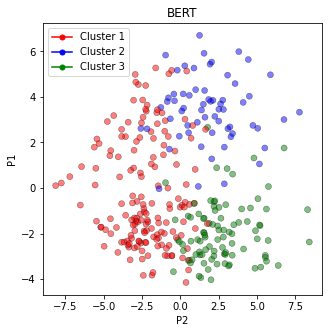

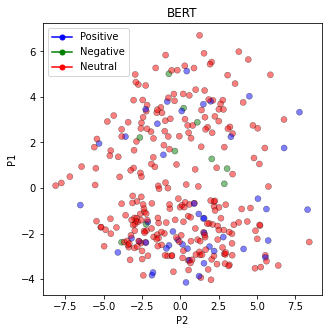

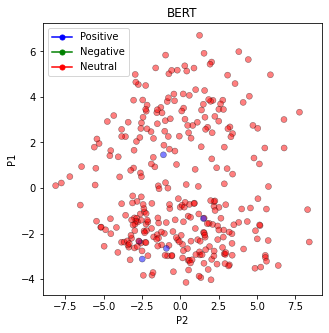

1it [00:47, 47.33s/it]
100%|██████████| 317/317 [00:33<00:00,  9.55it/s]


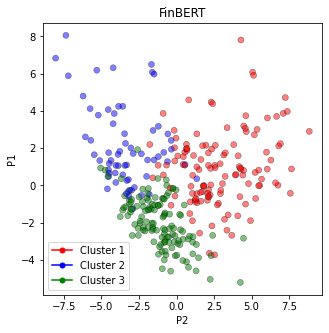

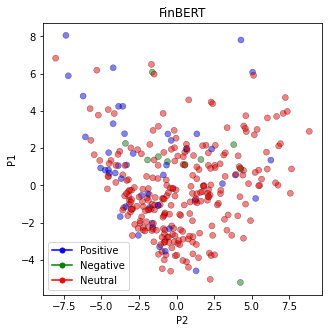

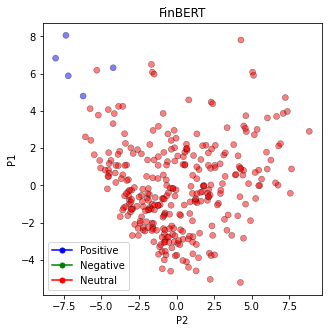

2it [01:33, 46.94s/it]Some weights of BertModel were not initialized from the model checkpoint at results/pretraining/bert-base/bert-base-final and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

100%|██████████| 317/317 [00:34<00:00,  9.16it/s]


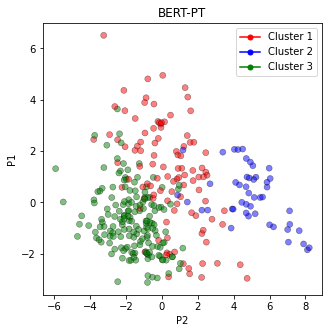

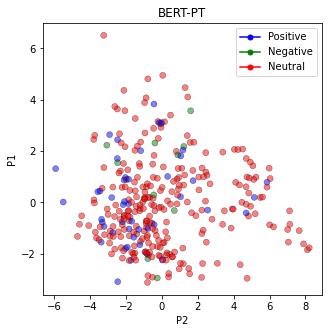

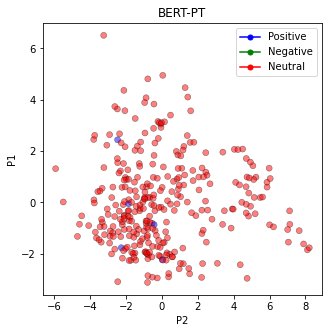

3it [02:19, 46.36s/it]


In [26]:
for model_name, model_label, tokenizer_name in tqdm(zip(models, model_labels, tokenizer_names)):
    save_clustering_plots(model_name, model_label, before=True, tokenizer_name=tokenizer_name)

### After

In [27]:
models = ['results/sentiment_analysis/bert-base/bert-base-final','results/sentiment_analysis/finbert-base/finbert-base-final','results/sentiment_analysis/pretrain-bert-base/pretrain-bert-base-final']
model_labels = ['BERT', 'FinBERT','BERT-PT']
tokenizer_names = ['bert-base-uncased','ProsusAI/finbert','bert-base-uncased']

0it [00:00, ?it/s]
100%|██████████| 317/317 [00:28<00:00, 11.14it/s]


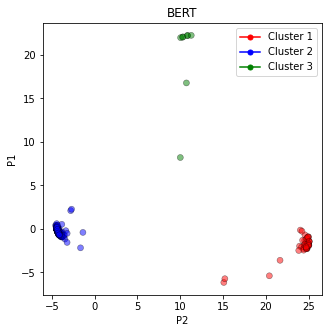

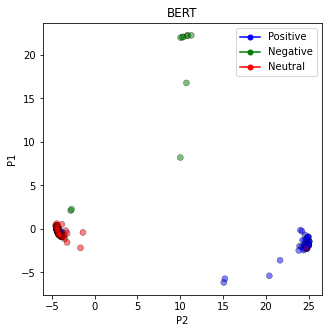

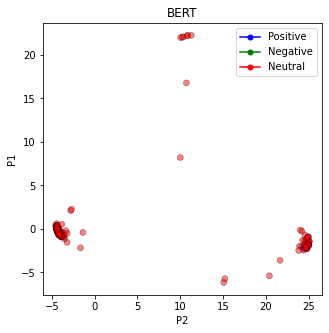

1it [00:45, 45.63s/it]
100%|██████████| 317/317 [00:30<00:00, 10.54it/s]


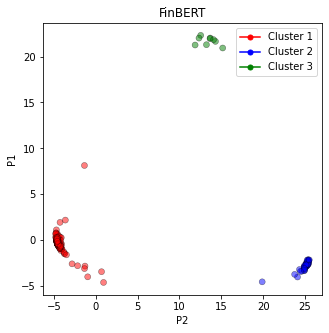

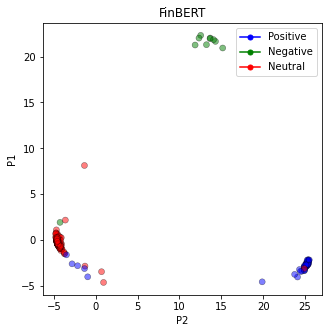

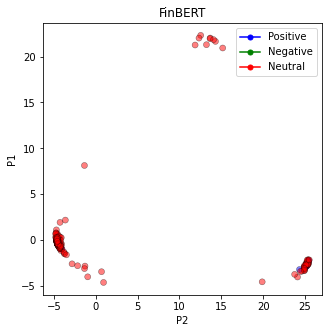

2it [01:26, 44.29s/it]
100%|██████████| 317/317 [00:37<00:00,  8.34it/s]


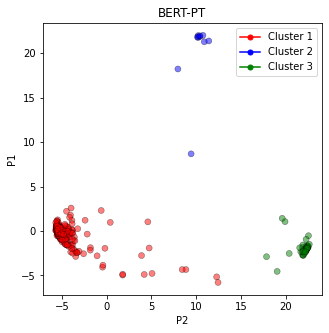

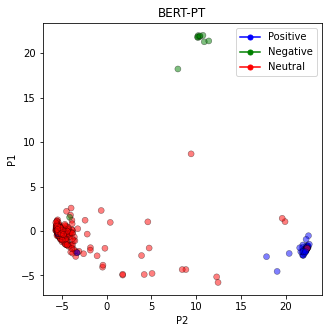

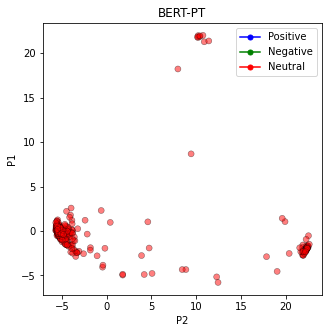

3it [02:16, 45.38s/it]


In [28]:
for model_name, model_label, tokenizer_name in tqdm(zip(models, model_labels, tokenizer_names)):
    save_clustering_plots(model_name, model_label, before=False, tokenizer_name=tokenizer_name)